**Description** Distributions of conditional effects to demonstrate that we're not just
averaging out real negative and positive effects.

This is the distribution of—

$$
\begin{align*}
\frac{\bar{\hat{Y}}_{i j \cdot 1} - \bar{\hat{Y}}_{i j \cdot 0}}{n}
\end{align*}
$$

—the difference between the treatment ($1$) and control ($0$) for each LM type ($i = 1,
2$ for BERT or GPT-2) and the dataset/task ($j = 1, 2, \dots, 25$).

**Required data**: posterior samples are stored in `main_*.nc` files. Obtain them by
running the notebooks in [`../fit_posteriors/`](../fit_posteriors/). Unfortunately all
of the inference data was saved (including for parameters we don't care about), so these
files are in the 10s of GBs. I'm trying to find a cheap and long-term way to share
these. Sorry.

**Estimated runtime**: 2 min.

In [1]:
import os
import sys
from typing import Literal

import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import polars as pl
import seaborn as sns
from tqdm.auto import tqdm
import xarray as xr

# sys hack to import from parent
sys.path.append(os.path.abspath(os.path.join("..")))
import utils

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
sns.set_theme(style="darkgrid")

# Input

In [3]:
num_train: Literal[50, 100] = 50

In [4]:
effect_name: Literal["evaluation bias", "pretraining boost"] = "evaluation bias"

if effect_name == "evaluation bias":
    effect = "treatment"  # sorry for confusing names. should be called bias or boost
    treatment, control = "test", "extra"
else:
    effect = "control"
    treatment, control = "extra", "base"

In [5]:
thingy: Literal["regular", "zero_shot", "gpt2-epochs-2"] = "regular"

_plot_title = f"$m={{{num_train}}}$ training observations"

if thingy == "regular":
    # num_tests: tuple[int] = (50, 100, 200, 500)
    num_tests: tuple[int] = (200, 500)
    accuracies_home_dir: str = os.path.join("..", "accuracies_from_paper")
    netcdfs_path: str = os.path.join("..", "netcdfs")
    title = _plot_title
elif thingy == "zero_shot":
    num_tests: tuple[int] = (100,)
    accuracies_home_dir: str = os.path.join("..", "accuracies_zero_shot")
    netcdfs_path: str = os.path.join("..", "netcdfs", "zero-shot")
    title = "Mistral 7B, zero-shot"
elif thingy == "gpt2-epochs-2":
    num_tests: tuple[int] = (50,)
    accuracies_home_dir: str = os.path.join("..", "accuracies_gpt2_epochs_2")
    netcdfs_path: str = os.path.join("..", "netcdfs", "gpt2-epochs-2")
    title = f"{_plot_title} (overtraining)"
else:
    raise ValueError("Not a valid thingy")

# Load

In [6]:
def _load(az_summary: az.InferenceData, num_correct_df: pl.DataFrame) -> pl.DataFrame:
    num_test: int = num_correct_df.select("num_test")[0].item()
    posterior_predictive: xr.DataArray = az.extract(
        az_summary, group="posterior_predictive"
    )
    predictions = posterior_predictive["p(num_correct, num_test)"]
    dfs: list[pl.DataFrame] = []
    for draw in tqdm(range(predictions.shape[1]), desc="Populating draws"):
        yhat = predictions[:, draw]
        num_correct_df_simulated = utils.num_correct_df_from_predicions(
            num_correct_df, yhat.to_numpy()
        )
        grouped = (
            num_correct_df_simulated.with_columns(pl.lit(draw).alias("draw"))
            # To save memory, and b/c we're not interested in subsample-level data,
            # average out the repeated subsamples. The variance will be communicated
            # through (the already done) repeated samples from the posterior predictive
            .group_by(["num_test", "lm_type", "dataset", "draw"], maintain_order=True)
            .mean()
            .with_columns(
                ((pl.col("treatment") - pl.col("control")) / num_test).alias("acc_diff")
            )
        )
        dfs.append(grouped)
    return pl.concat(dfs)


def load_all(num_tests: list[int], effect: str) -> tuple[pl.DataFrame, pl.DataFrame]:
    dfs_pred: list[pl.DataFrame] = []
    dfs_obs: list[pl.DataFrame] = []
    for num_test in tqdm(num_tests, "Processing each n"):
        num_correct_df = utils.load_all_num_correct(
            os.path.join(accuracies_home_dir, f"m{num_train}"), num_test
        )
        az_summary = az.from_netcdf(
            os.path.join(
                netcdfs_path,
                f"m{num_train}",
                f"main_m{num_train}_n{num_test}_{effect}.nc",
            )
        )
        dfs_pred.append(_load(az_summary, num_correct_df))
        dfs_obs.append(num_correct_df)
    return pl.concat(dfs_pred), pl.concat(dfs_obs)


df_pred, df_obs = load_all(num_tests, effect)

Processing each n:   0%|          | 0/2 [00:00<?, ?it/s]

Populating draws:   0%|          | 0/4000 [00:00<?, ?it/s]

Populating draws:   0%|          | 0/4000 [00:00<?, ?it/s]

# Calibration

In [7]:
group = ("num_test", "lm_type", "dataset")

In [8]:
pred_obs = (
    df_pred.group_by(group)
    .agg(((pl.col("control") / pl.col("num_test")).mean()).alias("pred"))
    .join(
        df_obs.group_by(group).agg(
            (pl.col(control) / pl.col("num_test")).mean().alias("obs")
        ),
        on=group,
    )
)

In [9]:
pred_obs_effect = (
    df_pred.group_by(group)
    .agg(pl.col("acc_diff").mean().alias("pred"))
    .join(
        df_obs.group_by(group).agg(
            (((pl.col(treatment) - pl.col(control)) / pl.col("num_test"))).mean().alias(
                "obs"
            )
        ),
        on=group,
    )
)

In [10]:
def plot_calibration(data: pl.DataFrame) -> plt.Axes:
    data = data.with_columns(
        pl.col("lm_type").replace(utils.lm_type_to_name),
        pl.col("num_test").replace({num_test: f"$n$ = {num_test}" for num_test in num_tests}),
    )
    ax = sns.scatterplot(data=data, x="obs", y="pred", hue="num_test", alpha=0.7)
    xlim = ax.get_xlim()
    plt.plot(xlim, xlim, linestyle="--", color="black", label="Perfect calibration")
    plt.legend()
    return ax

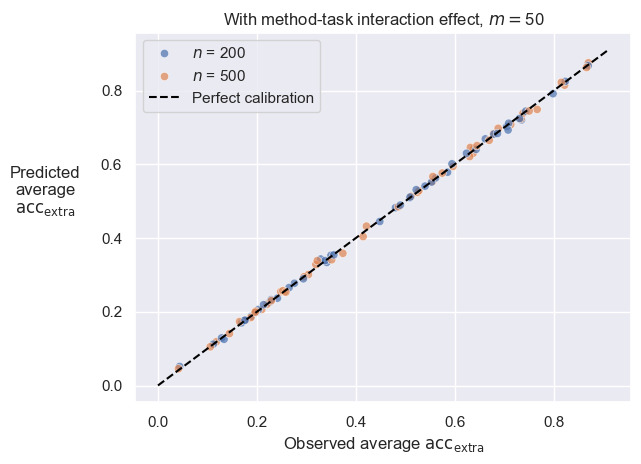

In [11]:
ax = plot_calibration(pred_obs)
ax.set_xlabel(f"Observed average {utils.texalo(control)}")
ax.set_ylabel(
    f"Predicted\naverage\n{utils.texalo(control)}", rotation="horizontal", labelpad=40
)
ax.set_title(
    f"With method-task interaction effect, $m = ${num_train}"
);

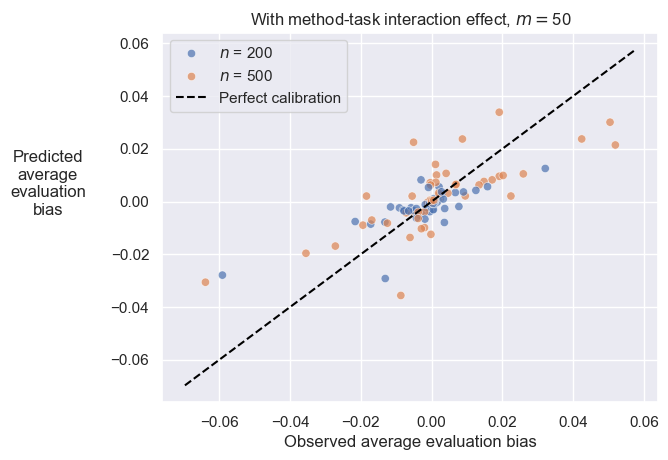

In [12]:
ax = plot_calibration(pred_obs_effect)
ax.set_xlabel(f"Observed average {effect_name}")
_effect_name = effect_name.replace(" ", "\n")
ax.set_ylabel(
    f"Predicted\naverage\n{_effect_name}", rotation="horizontal", labelpad=45
)
ax.set_title(
    f"With method-task interaction effect, $m = ${num_train}"
);

# Conditional plots

In [13]:
lm_type = "bert"

selected_datasets = [
    "amazon_counterfactual_en",
    "craigslist_bargains",
    "emo",
    "financial_phrasebank",
    "mtop_domain",
    "trec",
]

In [14]:
grouped_preds = df_pred.group_by(
    "num_test", "lm_type", "dataset", "draw", maintain_order=True
).mean()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


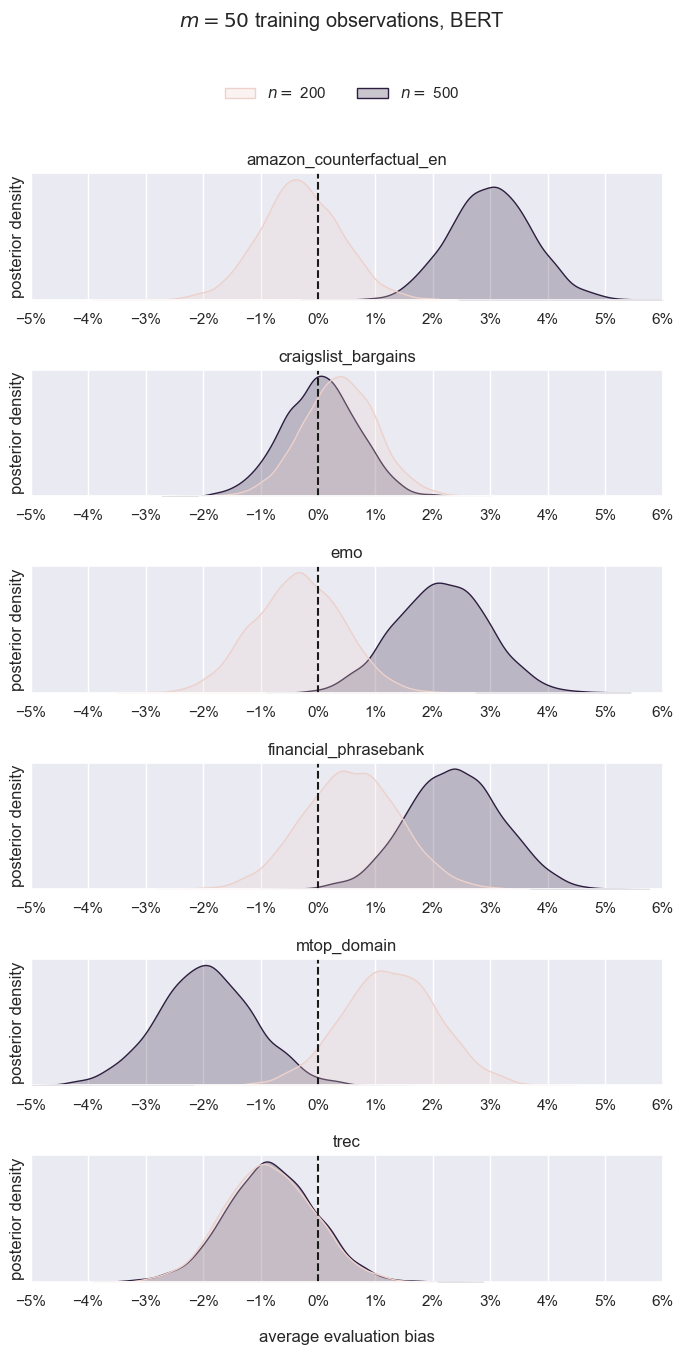

In [15]:
fig, axes = plt.subplots(nrows=len(selected_datasets), ncols=1)
fig.set_size_inches(7, (2 * len(selected_datasets)))

xlim = (-0.05, 0.05)

xticks = np.arange(xlim[0], xlim[1] + 0.01, 0.01)
# every 0.01

axes: list[plt.Axes] = [axes] if len(selected_datasets) == 1 else axes
for subplot_idx, dataset in enumerate(selected_datasets):
    ax = axes[subplot_idx]
    _ = ax.set_xlim(xlim)
    data = grouped_preds.filter(
        (pl.col("lm_type") == lm_type).and_(pl.col("dataset") == dataset)
    ).select(pl.col("num_test"), pl.col("acc_diff"))
    _ = sns.kdeplot(ax=ax, data=data, x="acc_diff", hue="num_test", fill=True)
    ax.axvline(0, linestyle="dashed", color="k")
    _ = ax.set_xlabel("")
    _ = ax.set_ylabel("posterior density")
    _ = ax.set_yticks([])
    _ = ax.set_xticks(xticks)
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
    _ = ax.set_title(
        # f"$m={{{num_train}}}$ training observations, "
        # f"$n={{{num_test}}}$ test observations"
        dataset
    )

_ = ax.set_xlabel(f"average {effect_name}", labelpad=15)

title_y_pos = 1.07 if thingy == "regular" else 1.25
fig.suptitle(f"{title}, {utils.lm_type_to_name[lm_type]}", y=title_y_pos)

fig.legend(
    handles=ax.legend_.legend_handles,
    labels=[f"$n =$ {t.get_text()}" for t in ax.legend_.get_texts()],
    ncol=2,
    loc="center",
    frameon=False,
    bbox_to_anchor=(0.5, 1.0),
)

for ax in axes:
    ax.legend().set_visible(False)

fig.tight_layout()
plt.subplots_adjust(bottom=0.01)